In [2]:
import heartpy as hp
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal,stats
import logging
from tqdm import tqdm
import os

In [3]:
DATA_ROOT = r"../data/raw/BPDataset/p00"

(2, 61000)
160.1109738049069


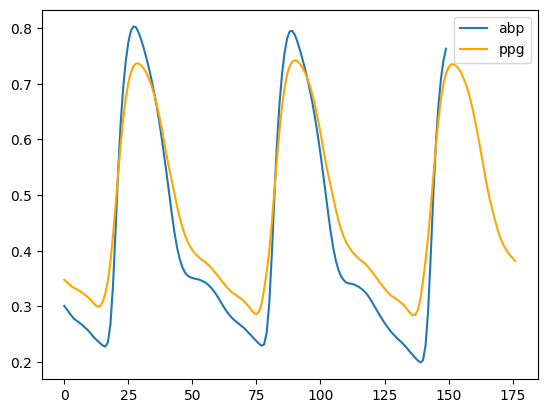

In [44]:
test = np.load(os.path.join(DATA_ROOT,"p00000"+"0","0000000_"+"0000"+".npy"))
print(test.shape)
print(np.nanmax(test[0]))
test[0] = (test[0]-np.nanmin(test[0]))/(np.nanmax(test[0])-np.nanmin(test[0]))
test[1] = (test[1]-np.nanmin(test[1]))/(np.nanmax(test[1])-np.nanmin(test[1]))
xstart = 57000 
xlen = 150
fig= plt.figure()
plt.plot(test[0,xstart:xstart+xlen],label="abp")
plt.plot(test[1,xstart-27:xstart+xlen],color='orange',label="ppg")
plt.legend()
# fig.set_xlim(xstart,xlen+xstart)

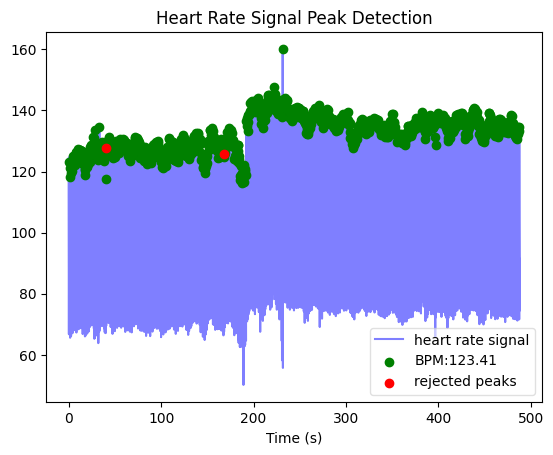

In [37]:
wd, m = hp.process(test[0], sample_rate = 125.0)
hp.plotter(wd,m)

In [12]:
# %%timeit -n 5 -r 2
xc_np = np.correlate(test[0], test[1], mode='valid')
print(np.argmin(xc_np),xc_np)

0 [10188519.43478978]


kが正->ppgは後退

In [38]:
from scipy import signal
correlation = signal.correlate(test[0], test[1], mode='full',method='fft')[test[0].size:]
lags = signal.correlation_lags(test[0].size, test[1].size, mode="full")[test[0].size:]
lag = lags[np.argmax(correlation)]
lag

27

In [39]:
rank = np.argsort(correlation)[::-1]
lags[rank[:10]]

array([27, 28, 26, 29, 88, 25, 89, 87, 90, 30])

In [15]:
test = np.load(os.path.join(DATA_ROOT,"p00000"+"0","0000000_"+"0000"+".npy"))
print(test.shape)
if lag < 0:
    test[0,:-abs(lag)] = test[0,abs(lag):]
else:
    test[1,:-abs(lag)] = test[1,abs(lag):]
test = test[:,:-abs(lag)]
print(test.shape)

(2, 61000)
(2, 60966)


In [16]:
def butterworth(sig,N=4,btype='bandpass',Wn=[0.5,8],fs=125):
    sos = signal.butter(N,Wn,btype,fs=fs,output='sos')
    return signal.sosfiltfilt(sos,sig)

In [1]:
import scipy
y_count = 0
n_count = 0
t_corr = 0.8
w = 2550
test = np.load(os.path.join(DATA_ROOT,"p00000"+"0","0000000_"+"0001"+".npy"))
# test_ac = test-test.mean(axis=1)[:,np.newaxis]

# test_ac /=( np.max(test_ac,axis=1)-np.min(test_ac,axis=1))[:,np.newaxis]
# test_norm = (test-np.min(test,axis=1)[:,np.newaxis])/(np.max(test,axis=1)-np.min(test,axis=1))[:,np.newaxis]

test_norm = butterworth(test_norm)
# print(test_norm.shape,np.max(test_norm,axis=1),np.min(test_norm,axis=1))
rn_avg = 0
ry_avg = 0
for i in range(0,len(test[1]),w):
    t = test[:,i:i+w]
    correlation = signal.correlate(t[0], t[1], mode='full')
    lags = signal.correlation_lags(t[0].size, t[1].size, mode="full")
    lag = lags[np.argmax(correlation)]
    # print(lag,t.shape)
    if lag == 0:
        pass
    elif lag < 0:
        t[0,:-abs(lag)] = t[0,abs(lag):]
        t = t[:,:-abs(lag)]
    else:
        t[1,:-abs(lag)] = t[1,abs(lag):]
        t = t[:,:-abs(lag)]
    r = scipy.stats.pearsonr(t[0],t[1]).statistic
    # print(r)
    # r = r / ((np.sqrt(np.sum(t[0]**2)-np.sum(t[0])**2)-np.sqrt(np.sum(t[1]**2)-np.sum(t[1])**2)))
    
    if r < t_corr: 
        n_count+=1
        rn_avg += r
        print(i,r,lag)
    else:
        ry_avg += r
        y_count+=1
# w filter (22, 24, 0.6063764220833109, 0.8987238536243735)
# w/o filter  (20, 26, 0.5965563205850931, 0.8980793577374475)   
y_count,n_count,rn_avg/n_count,ry_avg/y_count

NameError: name 'np' is not defined

In [4]:
test_ac = test-test.mean(axis=1)[:,np.newaxis]
np.sum(test_ac,axis=1)

NameError: name 'test' is not defined

In [71]:
xc_ab = np.correlate(test_ac[0], test_ac[1], mode='full')
xc_ab/=(np.linalg.norm(test_ac[0], ord=2) * np.linalg.norm(test_ac[0], ord=2))
xc_ab

array([2.92779606e-07, 5.24611840e-07, 6.48700473e-07, ...,
       1.36700347e-07, 5.52973719e-08, 1.01664475e-08])

In [74]:
np.argmax(xc_ab),xc_ab.shape

(60965, (121999,))

In [81]:
len(test[1])

61000

In [93]:
window = 10000
for i in range(len(test[1])//window-1):
    a = test[:,i*window:i*window+window]
    corr = np.correlate(a[0], a[1], mode='full')
    print(np.nanargmax(corr)-window,corr[:np.nanargmax(corr)])

26 [7.40118049e+01 1.49967156e+02 2.33384865e+02 ... 1.76924917e+06
 1.77407298e+06 1.77699031e+06]
-35 [1.39897727e+02 2.83311847e+02 4.31031124e+02 ... 1.75787873e+06
 1.76417375e+06 1.76858696e+06]
-34 [1.54658196e+02 3.16601181e+02 4.84566889e+02 ... 1.89572769e+06
 1.90109357e+06 1.90454380e+06]
27 [2.62403420e+02 5.21916825e+02 7.79709943e+02 ... 1.90795152e+06
 1.91241424e+06 1.91482074e+06]
27 [1.05182412e+02 2.11891740e+02 3.19924586e+02 ... 1.86455495e+06
 1.86904586e+06 1.87146884e+06]


In [55]:
%%timeit -n 5 -r 2
xc_np = np.correlate(test_norm[0], test_norm[1], mode='full')
print(xc_np)
print()

[0.06014718 0.12977872 0.22266009 ... 0.38649663 0.28757256 0.16485101]
[0.06014718 0.12977872 0.22266009 ... 0.38649663 0.28757256 0.16485101]
[0.06014718 0.12977872 0.22266009 ... 0.38649663 0.28757256 0.16485101]
[0.06014718 0.12977872 0.22266009 ... 0.38649663 0.28757256 0.16485101]
[0.06014718 0.12977872 0.22266009 ... 0.38649663 0.28757256 0.16485101]
[0.06014718 0.12977872 0.22266009 ... 0.38649663 0.28757256 0.16485101]
[0.06014718 0.12977872 0.22266009 ... 0.38649663 0.28757256 0.16485101]
[0.06014718 0.12977872 0.22266009 ... 0.38649663 0.28757256 0.16485101]
[0.06014718 0.12977872 0.22266009 ... 0.38649663 0.28757256 0.16485101]
[0.06014718 0.12977872 0.22266009 ... 0.38649663 0.28757256 0.16485101]
11.7 s ± 17.4 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


In [57]:
np.argmin(xc_np)

0

In [18]:
# test = test.astype(np.float64)
test_norm = (test-np.min(test,axis=1)[:,np.newaxis])
test_norm = test_norm/(np.max(test,axis=1)-np.min(test,axis=1))[:,np.newaxis]
np.max(test_norm[0]),np.max(test_norm[1]),np.min(test_norm[0]),np.min(test_norm[1])

(1.0, 1.0, 0.0, 0.0)

In [50]:
np.min(test,axis=1),np.max(test,axis=1),np.max(test,axis=1)

(array([50.16289509,  0.        ]),
 array([160.1109738 ,   4.00195503]),
 array([160.1109738 ,   4.00195503]))

In [46]:
test-np.min(test,axis=1)[:,np.newaxis]

array([[16.90006008, 19.19573298, 25.2035578 , ..., 26.2781281 ,
        31.65097957, 41.22442401],
       [ 1.75953079,  1.71847507,  1.68426197, ...,  1.64418377,
         1.6001955 ,  1.5659824 ]])

- hr : ppg
- peaklist : peak の index（rejected含む）
- removed_beats : rejected peaks の index
- binary_peaklist : 0=rejected

In [28]:
wd

{'hr': array([1.66177908, 1.62658847, 1.59628543, ..., 2.8572825 , 2.81915934,
        2.77321603]),
 'sample_rate': 125.0,
 'peaklist': [41,
  102,
  162,
  222,
  282,
  342,
  403,
  462,
  521,
  582,
  641,
  701,
  761,
  820,
  880,
  948,
  974,
  986,
  1115,
  1174,
  1234,
  1293,
  1353,
  1411,
  1470,
  1529,
  1591,
  1649,
  1709,
  1769,
  1829,
  1889,
  1948,
  2009,
  2070,
  2132,
  2192,
  2254,
  2316,
  2377,
  2439,
  2500,
  2563,
  2625,
  2687,
  2748,
  2810,
  2907,
  2968,
  3008,
  3070,
  3131,
  3192,
  3252,
  3314,
  3374,
  3439,
  3503,
  3562,
  3580,
  3694,
  3718,
  3779,
  3842,
  3900,
  3963,
  4056,
  4115,
  4172,
  4228,
  4286,
  4345,
  4404,
  4463,
  4522,
  4581,
  4640,
  4699,
  4757,
  4816,
  4873,
  4936,
  4994],
 'ybeat': [3.0087976539589443,
  2.9374389051808407,
  2.7888563049853374,
  2.95405669599218,
  3.002932551319648,
  2.9745845552297165,
  2.843597262952102,
  2.758553274682307,
  2.8455522971652005,
  2.915933528836

In [19]:

def butterworth(sig,N=4,btype='bandpass',Wn=[0.5,8],fs=125):
    sos = signal.butter(N,Wn,btype,fs=fs,output='sos')
    return signal.sosfiltfilt(sos,sig)

def hampel(sig,k=3,nsigma=3):
    median = signal.medfilt(sig,kernel_size=k)
    deviation = np.abs(sig-median)
    median_deviation = signal.medfilt(deviation,kernel_size=k)
    threshold = 1.4826 * nsigma*median_deviation
    outliers = np.where(deviation > threshold)[0]
    sig[outliers] = median[outliers]
    return sig
    
def minmax_norm(sig):
    return (sig-np.nanmin(sig))/(np.nanmax(sig)-np.nanmin(sig))
# def zscore_norm(sig):
    
def detect_flat(sig,window,t_flat):
    sig = sig.T
    len_data = sig.shape[1]
    flat_locs_abp = np.ones((len_data - window+1,), dtype=int)
    flat_locs_ppg = np.ones((len_data - window+1,), dtype=int)
    # print(flat_locs_abp.shape)
    # Get the locations where i == i+1 == i+2 ... == i+window
    # efficient-ish sliding window
    # print(data[1, :len_data - window].shape,data[1, 0:len_data - window + 0].shape)
    for i in range(1, window):
        # print(data[1, :len_data - window+1].shape, data[1, i:len_data - window + i+1].shape)
        tmp_abp = (sig[0, :len_data - window+1] == sig[0, i:len_data - window + i+1])
        tmp_ppg = (sig[1, :len_data - window+1] == sig[1, i:len_data - window + i+1])
        flat_locs_abp = (flat_locs_abp & tmp_abp)
        flat_locs_ppg = (flat_locs_ppg & tmp_ppg)
        # print(tmp_abp.shape,tmp_ppg.shape)
        # Extend to be the same size as data
    flat_locs_ppg = np.concatenate((flat_locs_ppg, np.zeros((window - 1,), dtype=bool)))
    flat_locs_abp = np.concatenate((flat_locs_abp, np.zeros((window - 1,), dtype=bool)))
    # print(flat_locs_abp.shape,flat_locs_ppg.shape)
    flat_locs_ppg2 = flat_locs_ppg.copy()
    flat_locs_abp2 = flat_locs_abp.copy()
    # print(flat_locs_abp2.shape,flat_locs_ppg2.shape)
        
    # Mark the ends of the window
    for i in range(1, window):
        flat_locs_abp[i:] = flat_locs_abp[i:] | flat_locs_abp2[:len_data-i]
        flat_locs_ppg[i:] = flat_locs_ppg[i:] | flat_locs_ppg2[:len_data-i]
        
    # Percentages
    per_abp = np.sum(flat_locs_abp) / len_data
    per_ppg = np.sum(flat_locs_ppg) / len_data
    if per_abp > t_flat or per_ppg > t_flat:
        logging.info(f"invalid because of flat lines: {per_ppg}, {per_abp},{np.sum(flat_locs_abp)},{np.sum(flat_locs_ppg)},{np.nanmax(flat_locs_abp)},{np.nanmax(flat_locs_ppg)}")
        return True,None,None
    else:
        return False,flat_locs_ppg,flat_locs_abp
    



In [20]:
def fill_rejected_valleys(sig,v):
    diff_v= np.diff(v)
    # [0,1,1,0,0,1,1,0,0]
    # [ 1,  0, -1,  0,  1,  0, -1,  0]
    old = 0
    old_i = -1
    for i,b in enumerate(diff_v):
        if b:
            if old_i < 0 and b > 0:
                sig[:v[i+1],:]=np.nan
            elif b > 0:
                sig[v[i]:v[old_i+1],:]=np.nan
            old = b
            old_i = i
    if old < 0:
        sig[:v[old_i+1],:]=np.nan

- flat (detect valleys)
- align signal (based on valleys)
- 相関係数で除去 (別で準備)
- 最大値最小値を記録して正規化

In [29]:
def flat(sig,plot=False,abp_norm=(199.98749589709124, 50.0),xfrom=0,xlen=100000,remove_rejected_peaks=False,align_signal=False,use_autocorr_filter=False):
    if sig is None:
        print("sig is none")
        return None
    w_flat = 15    # flat lines window
    w_peaks = 5    # flat peaks window
    w_fix = 15     # flat join window
    w_corr = 2550
    t_nan = 125 * 120
    # thresholds
    t_peaks = 0.05 # percentage of tolerated flat peaks
    t_flat = 0.1  # percentage of tolerated flat lines
    t_corr = 0.8
    # def find_sig_begin(sig):
    #     nan_mask = np.isnan(sig[:,0]) | np.isnan(sig[:,1])
    #     nan_begin_locs = np.where(np.diff(nan_mask)==1)
    #     nan_end_locs = np.where(np.diff(nan_mask)==-1)
        
    #     # print(len(nan_locs))
    #     if not len(nan_locs):
    #         # print("no nan")
    #         target = sig
    #         for i in range(0,len(target)-px,px):
    #             s.append(target[i:i+px,:].astype(dtype))
    #     else:
    #         for n in range(len(nan_locs)-1):
    #             target = sig[nan_locs[n]+1:nan_locs[n+1]]
    #             for i in range(0,len(target)-px,px):
    #                 s.append(target[i:i+px,:].astype(dtype))
        
    if plot:
        sig_processed = sig.copy()
    # 0 nanでorをとる
    nan_mask = np.isnan(sig[:,0]) | np.isnan(sig[:,1])
    s = np.sum(~nan_mask)
    if  s < t_nan:
        logging.info(f"invalid because of short valid signal: {s}")
        print(f"invalid because of short valid signal: {s}")
        return None
    sig = sig[~nan_mask]
    # ppg_norm = (np.nanmax(sig[:,1]),np.nanmin(sig[:,1]))
    # ppg normalize
    if (sig[:,1]>1).any():
        sig[:,1] /= 4 
    # ppgfilter
     
    # sig[:,0] = (sig[:,0] - abp_norm[1])/(abp_norm[0]-abp_norm[1])
    # sig[:,1] = (sig[:,1] - ppg_norm[1])/(ppg_norm[0]-ppg_norm[1])
    # 0b autocorr align
    if align_signal:
        for i in range(0,len(sig),w_corr):
            t = sig[i:i+w_corr]
            correlation = signal.correlate(t[:,0], t[:,1], mode='full')
            lags = signal.correlation_lags(t[:,0].size, t[:,1].size, mode="full")
            lag = lags[np.argmax(correlation)]
            # print(lag,t.shape)
            # print("before 0b",lag,sig.shape)
            if lag == 0:
                pass
            elif lag < 0:
                t[:-abs(lag),0] = t[abs(lag):,0]
                t[-abs(lag):] = np.nan
            else:
                t[:-abs(lag),1] = t[abs(lag):,1]
                t[-abs(lag):] = np.nan
            # print("after 0b",lag,sig.shape)
            if use_autocorr_filter:
                r = scipy.stats.pearsonr(t[:-abs(lag),0],t[:-abs(lag),1]).statistic
                if r < 0.8:
                    t[:] = np.nan
            sig[i:i+w_corr] = t
            sig[i] = np.nan
        # print(r)
        # r = r / ((np.sqrt(np.sum(t[0]**2)-np.sum(t[0])**2)-np.sqrt(np.sum(t[1]**2)-np.sum(t[1])**2)))

    
    # 1, 2
    is_invalid,flat_locs_ppg,flat_locs_abp=detect_flat(sig,w_flat,t_flat)
    if is_invalid:
        print("invalid 1")
        return None
    # 3 find peaks, calcurate flat peaks rate
    # peaks_abp, peaks_info_abp = signal.find_peaks(sig[:,0],distance=35,plateau_size=w_peaks)
    peaks_ppg, peaks_info_ppg = signal.find_peaks(sig[:,1],distance=35,plateau_size=w_peaks)
    # 4 delete data if too much flat lines/peaks
    # if len(peaks_info_ppg['plateau_sizes']) == 0 or len(peaks_info_abp['plateau_sizes']) == 0:
    if len(peaks_info_ppg['plateau_sizes']) == 0:
        print("invalid 4")
        return None
    len_data=len(sig)
    per_ppg =len(peaks_info_ppg['plateau_sizes'])/ len(peaks_info_ppg['plateau_sizes'])
    # per_abp =len(peaks_info_abp['plateau_sizes'])/len(peaks_info_abp['plateau_sizes'])
    # del
    if per_ppg > t_peaks:
        logging.info(f"invalid because of flat lines: {per_ppg}")
        print(f"invalid because of flat lines: {per_ppg}")
        return None
    # if per_abp > t_peaks or per_ppg > t_peaks:
    #     logging.info(f"invalid because of flat lines: {per_ppg}, {per_abp}")
    #     print(f"invalid because of flat lines: {per_ppg}, {per_abp}")
    #     return None
    # 5 find valleys
    print(np.count_nonzero(np.isnan(sig)))
    try:
        
        sig_begin_idx = find_sig_begin(sig)
        # wd_abp, _ = hp.process(-sig[:,0], 125.0)
        wd_ppg, _ = hp.process(-sig[:,1], 125.0)
    except Exception as e:
        print(e)
        fig,axes = plt.subplots(2,1)
        axes[0].plot(-sig[27000:34000,0])
        axes[0].set_title("ABP")
        axes[1].plot(-sig[:,1])
        axes[1].set_title("PPG")
        fig.tight_layout()
    # valleys_abp = wd_abp['peaklist'] & wd_abp['binary_peaklist']
    valleys_ppg = wd_ppg['peaklist'] & wd_ppg['binary_peaklist']

    # 6a fill valley-valley with nan if flat line exists
    # connect_valley_locs_???[i] = True if there's flat line between valleys[i] and valleys[i+1] 
    # ppg
    # connect_valley_locs_ppg = np.zeros_like(valleys_ppg)
    # for i in range(valleys_ppg.shape[0]-1):
    #     connect_valley_locs_ppg[i] = np.any(flat_locs_ppg[valleys_ppg[i]:valleys_ppg[i+1]])
    # # print("total connecting valleys:",np.sum(connect_valley_locs_ppg),valleys_ppg.shape[0]-1)
    # for j in range(connect_valley_locs_ppg.shape[0]-1):
    #     if connect_valley_locs_ppg[j]:
    #         sig[valleys_ppg[j]:valleys_ppg[j+1],:]=np.nan
    # # abp
    # connect_valley_locs_abp = np.zeros_like(valleys_abp)
    # for i in range(valleys_abp.shape[0]-1):
    #     connect_valley_locs_abp[i] = np.any(flat_locs_abp[valleys_abp[i]:valleys_abp[i+1]])
    # for j in range(connect_valley_locs_abp.shape[0]-1):
    #     if connect_valley_locs_abp[j]:
    #         sig[valleys_abp[j]:valleys_abp[j+1],:]=np.nan 
    sig[np.where(flat_locs_ppg)[0],:] = np.nan
    sig[np.where(flat_locs_abp)[0],:] = np.nan
    
    # 6b same nan fill with rejected peaks
    print("before fill_nan_diff",np.count_nonzero(np.isnan(sig)))
    # fill_rejected_valleys(sig[:,0],wd_abp['binary_peaklist'])
    fill_rejected_valleys(sig[:,1],wd_ppg['binary_peaklist'])
    print("after fill_nan_diff",np.count_nonzero(np.isnan(sig)))
    
    # 7 nan del
    starts_with_nan = np.isnan(sig[0,0])
    nan_diff = np.diff(np.isnan(sig[:,0]))
    nan_border = np.where(nan_diff==1)[0]
    if not starts_with_nan:
        nan_border = nan_border[1:-1]
    if len(nan_border) % 2 == 1:
        nan_border = nan_border[:-1]
    nan_border = nan_border.reshape(-1,2)
    nan_length = nan_border[:,1]-nan_border[:,0]
    
    # print(nan_border[:5],nan_length[:30])
    for i,l in enumerate(nan_length):
        if l < t_nan:
            sig[nan_border[i,0]:nan_border[i,1],:]=np.nan
    # print(len(nan_diff_pos),nan_diff_pos[:5],len(nan_diff_neg),nan_diff_neg[:5])
    nan_mask = np.isnan(sig[:,0])
    # leave single nan
    nan_border = nan_border[np.where(nan_length < t_nan)[0]]
    nan_mask[nan_border] = False
    sig = sig[~nan_mask,:]
    if len(sig) < t_nan:
        print("invalid last")
        return None
    # print("before:",len_data,"after:",len(sig))
    if plot:
        x = np.arange(0,len(sig))
        plt.figure(figsize=(12,4))
        plt.subplot(2,1,1)
        # plt.plot(x,sig_processed[:,0],label='-.',color='black')
        plt.plot(x,sig[:,0])
        # plt.scatter(x[valleys_ppg], sig[valleys_ppg,0], color='red',s=24)
        plt.xlim(xfrom,xfrom+xlen)
        plt.subplot(2,1,2)
        # plt.plot(x,sig_processed[:,1],label='-.',color='black')
        plt.plot(x,sig[:,1])
        # plt.scatter(x[valleys_abp], sig[valleys_abp,1], color='red',s=24)
        plt.xlim(xfrom,xfrom+xlen)
        plt.show()
    return sig

(61000, 2)
0
before fill_nan_diff 0
after fill_nan_diff 0
0
before fill_nan_diff 0
after fill_nan_diff 0
60776

----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detectable heart rate present in signal
- very noisy signal (consider filtering and scaling)
If you're sure the signal contains heartrate data, consider filtering and/or scaling first.
----------------



UnboundLocalError: local variable 'wd_abp' referenced before assignment

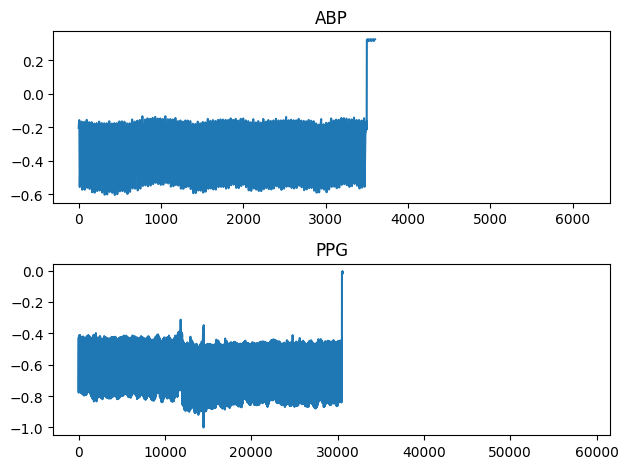

In [30]:
test = np.load(os.path.join(DATA_ROOT,"p00000"+"0","0000000_"+"0000"+".npy")).reshape(-1,2)
print(test.shape)
test1 = flat(test)
test2 = flat(test,remove_rejected_peaks=True)
test3 = flat(test,remove_rejected_peaks=False,align_signal=True)
test4 = flat(test,remove_rejected_peaks=False,align_signal=True,use_autocorr_filter=True)
test5 = flat(test,remove_rejected_peaks=True,align_signal=True,use_autocorr_filter=True)

TypeError: 'NoneType' object is not subscriptable

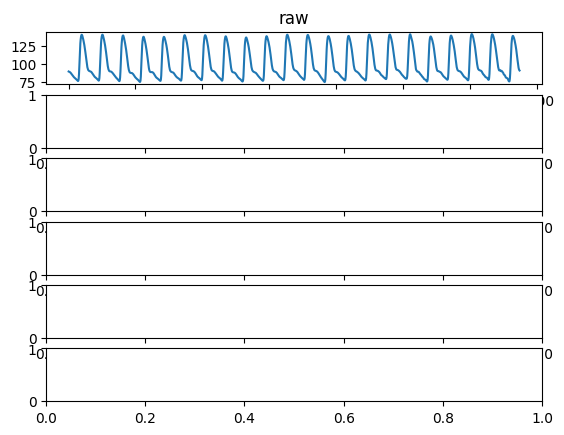

In [183]:
xstart = 29700 
xlen = 1350
fig,axes = plt.subplots(6,1)
axes[0].plot(test[0,xstart:xstart+xlen])
axes[0].set_title("raw")
axes[1].plot(test1[0,xstart:xstart+xlen])
axes[2].plot(test2[0,xstart:xstart+xlen])
axes[3].plot(test3[0,xstart:xstart+xlen])
axes[4].plot(test4[0,xstart:xstart+xlen])
axes[5].plot(test5[0,xstart:xstart+xlen])
fig.tight_layout()

In [38]:
np.diff([0,1,1,0,0,1,1,0,0])

array([ 1,  0, -1,  0,  1,  0, -1,  0])

In [ ]:
xc_np = np.correlate(sig[0], b, mode='full')

In [25]:
test.shape

(61000, 2)

In [32]:
try:
    wd_abp, _ = hp.process(-test[:,0], 125.0)
    # wd_abp, _ = hp.process(-test[:,1], 125.0)
    
except Exception as  e:
    print(e)
print(wd_abp)


{'hr': array([ 74.82916775,  66.52567002,  45.66923749, ..., 140.03875048,
       140.19124315, 140.29192741]), 'sample_rate': 125.0, 'peaklist': array([   31,    62,    93, ..., 30437, 30467, 30514], dtype=int64), 'ybeat': array([ 74.58494722,  75.36645289,  76.29449087, ...,  67.99099315,
        70.04244553, 140.73376514]), 'rolling_mean': array([ 59.14666377,  59.14666377,  59.14666377, ..., 144.74449461,
       144.74449461, 144.74449461]), 'RR_list': array([248., 248., 240., ..., 248., 240., 376.]), 'RR_indices': [(31, 62), (62, 93), (93, 123), (123, 154), (154, 185), (185, 216), (216, 246), (246, 276), (276, 306), (306, 337), (337, 367), (367, 397), (397, 427), (427, 457), (457, 487), (487, 517), (517, 547), (547, 577), (577, 608), (608, 638), (638, 669), (669, 698), (698, 729), (729, 759), (759, 790), (790, 820), (820, 850), (850, 881), (881, 911), (911, 942), (942, 972), (972, 1003), (1003, 1034), (1034, 1064), (1064, 1095), (1095, 1125), (1125, 1155), (1155, 1186), (1186, 121

In [33]:
print(wd_abp.keys())

dict_keys(['hr', 'sample_rate', 'peaklist', 'ybeat', 'rolling_mean', 'RR_list', 'RR_indices', 'RR_diff', 'RR_sqdiff', 'rrsd', 'best', 'removed_beats', 'removed_beats_y', 'binary_peaklist', 'RR_masklist', 'RR_list_cor', 'nn20', 'nn50', 'poincare', 'breathing_signal', 'breathing_psd', 'breathing_frq'])


(2, 21000)


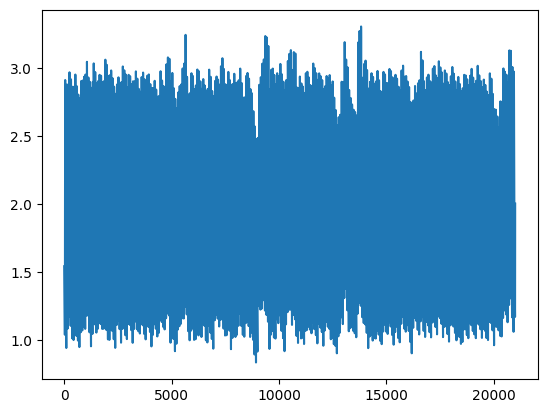

In [93]:
xs = 23000
xlen=3000
test = np.load(os.path.join(DATA_ROOT,"p00000"+"0","0000000_"+"0005"+".npy"))
print(test.shape)
# plt.plot(test[1,xs:xs+xlen])
plt.plot(test[1])
median = np.median(test[1])
avg = np.average(test[1])
std = np.std(test[1])


In [105]:
def plot_hist(test,p=(0.5,99.5)):
    median = np.median(test[1])
    avg = np.average(test[1])
    std = np.std(test[1])
    p0 = np.percentile(test[1], p[0])
    p1 = np.percentile(test[1], p[1])
    plt.hist(test[1],bins=100)
    plt.axvline(median,c='orange')
    plt.axvline(avg,c='red')
    plt.axvline(p0,c='black')
    plt.axvline(p1,c='black')
    plt.title(f"median:{median:.3f}, average:{avg:.3f}, std:{std:.3f},{int(p[0]*100):2.1f}%: {p0:.3f}, {int(p[1]*100):2.1f}%:{p1:.3f})")

(0.9765395894428153, 3.07332355816227)


(21000,)

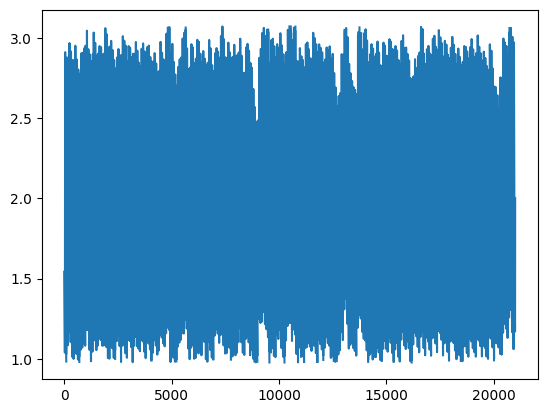

In [95]:
import copy
test2 = copy.deepcopy(test[1])
threshold =(np.percentile(test[1], p[0]),np.percentile(test[1], p[1]))
print(threshold)
cond_low = test2 < threshold[0]
cond_high = test2 > threshold[1]
test2[cond_low] = np.nan
test2[cond_high] = np.nan
plt.plot(test2)
test2.shape

In [5]:
from tqdm import trange
min = []
max = []
for i in range(12):
    min_ = []
    max_ = []
    for j in trange(1000):
        t = np.load(os.path.join(DATA_ROOT,f"p0000{i:02d}",f"0000000_{j:04d}.npy"))
        min_.append(np.nanmin(t[1]))
        max_.append(np.nanmax(t[1]))
    min.append(np.array(min_))
    max.append(np.array(max_))

100%|██████████| 1000/1000 [00:03<00:00, 263.27it/s]


In [6]:
min_2 = np.concatenate(min)
max_2 = np.concatenate(max)
min_2.shape, max_2.shape

((12000,), (12000,))

Text(0.5, 1.0, 'ppg: min value')

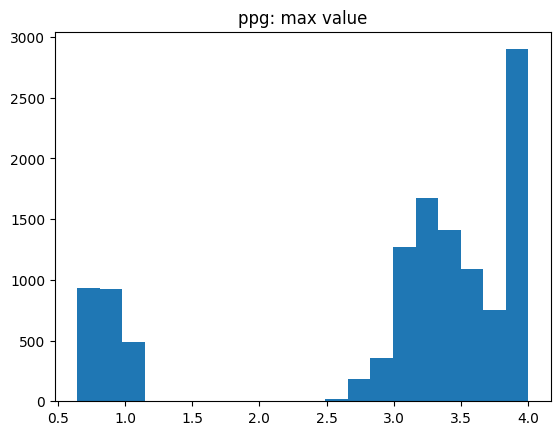

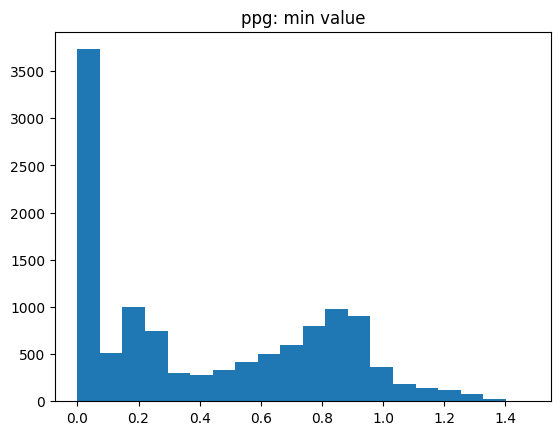

In [7]:
plt.hist(max_2,bins=20)
plt.title("ppg: max value")
plt.figure()
plt.hist(min_2,bins=20)
plt.title("ppg: min value")


In [9]:
zero_min_ppg = np.where(min_2<0.01)[0]
high_min_ppg = np.where(min_2>1.0)[0]
zero_min_ppg.shape,high_min_ppg.shape

((3329,), (638,))

In [111]:
a = np.where(max_2<2)[0]
a.shape,a

((2339,), array([   19,    20,    21, ..., 11976, 11977, 11978], dtype=int64))

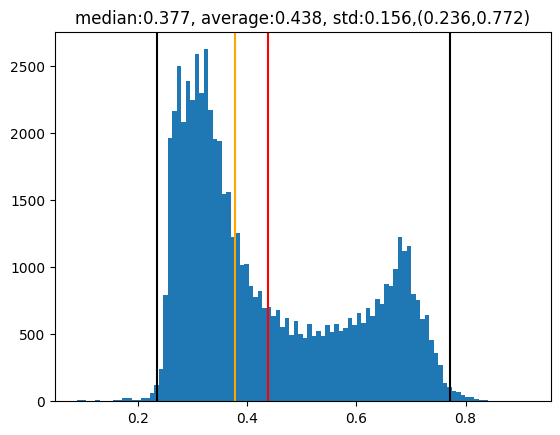

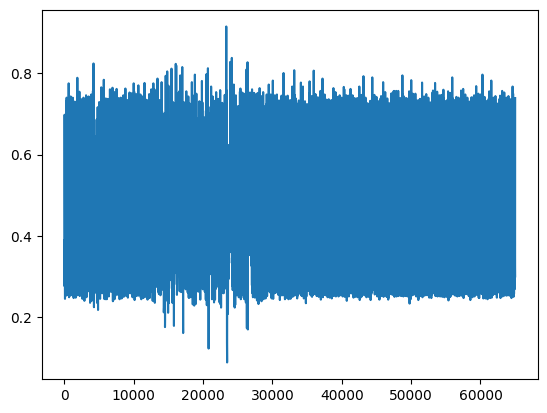

In [116]:
x = a[2338]
test3 = np.load(os.path.join(DATA_ROOT,f"p0000{x//1000:02d}",f"0000000_{x%1000:04d}.npy"))
plot_hist(test3)
plt.figure()
plt.plot(test3[1])